In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.utils import train_keys, target_keys, ScaleData

In [4]:
df_train

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
0,-0.257868,-0.509208,0.148718,2.288746,-0.995487,1.538715,0.812978,-0.795886,-0.664840,-0.351998,-0.180006,-0.299152,0.064693,0.750068,-0.767929
1,-0.436900,0.121736,-0.292210,-0.531209,0.262809,0.026767,0.042740,-0.436493,0.166027,-0.451055,-0.224542,0.499898,-0.113581,-0.108048,-0.885155
2,-0.203566,-0.511800,0.288931,2.966545,-0.979355,0.305774,0.733947,-0.813382,-0.676370,-0.313832,-0.418043,-0.670386,-0.399421,0.348086,-0.438060
3,-0.140948,-0.244065,-0.061599,-0.343891,0.598816,0.224830,0.097840,0.442686,-0.026061,-0.289819,-0.104851,0.597475,-0.121836,-1.558666,-0.450117
4,-0.250366,-0.298806,-0.292210,-0.531209,0.530836,0.714251,0.042740,0.455390,-0.658780,2.126567,0.049229,0.466821,1.359846,-0.619788,-1.093930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17672639,-0.473282,-0.446886,-0.292210,-0.531209,0.472240,-0.783072,0.042740,2.790935,-0.005839,-0.370529,-0.273492,-0.430011,-0.215494,-0.108048,0.865153
17672640,-0.317513,-0.938364,-0.292210,-0.531209,-0.213778,0.074336,0.042740,0.212415,-0.571527,-0.466250,-0.068233,-0.357783,-0.115564,-0.108048,-0.079589
17672641,0.113052,0.264481,-0.292210,-0.531209,0.606703,-1.214857,0.042740,-0.353318,0.208109,-0.461651,-0.117794,0.657153,-1.522403,-0.108048,-0.607980
17672642,-0.090096,0.171790,0.428151,0.248334,0.565513,-1.123934,-0.054967,-0.531630,0.102214,-0.109040,-0.312683,0.555815,-1.054381,-0.226684,-0.115542


In [3]:
train = "/share/rcifdata/jbarr/UKAEAGroupProject/data/QLKNN_train_data.pkl"
df_train = pd.read_pickle(train)
df_train = df_train[train_keys]
df_train, scaler = ScaleData(df_train)

df_train.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07
mean,-4.244571e-17,-2.204141e-15,-1.845331e-14,9.872596e-16,1.443307e-15,5.825100e-16,-2.163914e-14,1.116600e-15,-1.048156e-16,8.099105e-16,-8.453134e-16,9.617863e-16,1.647093e-15,1.539637e-14,1.514649e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.384711e+01,-6.585977e+00,-1.884677e+01,-2.065468e+00,-1.685289e+00,-1.270876e+00,-2.605210e+01,-1.226404e+00,-2.207143e+00,-4.272697e+00,-1.542753e+01,-7.614730e+00,-1.810760e+00,-3.966175e+00,-3.129009e+00
25%,-4.040953e-01,-5.670599e-01,-2.922102e-01,-5.312093e-01,-9.628142e-01,-7.966956e-01,4.273997e-02,-7.364278e-01,-6.534275e-01,-4.755039e-01,-3.499717e-01,-5.471105e-01,-2.686078e-01,-1.080478e-01,-7.260516e-01
50%,-2.005211e-01,-2.616720e-01,-2.922102e-01,-5.312093e-01,-1.396549e-01,-1.542101e-01,4.273997e-02,-2.877295e-01,-3.921313e-01,-3.348355e-01,-1.956296e-01,-2.503222e-01,-2.116415e-01,-1.080478e-01,-1.348429e-01
75%,9.590093e-02,2.096182e-01,-2.717016e-02,1.510355e-01,9.351353e-01,5.066278e-01,4.273997e-02,4.397159e-01,2.817471e-01,8.098745e-02,4.703473e-02,2.638433e-01,-9.624531e-02,-1.080478e-01,5.857065e-01
max,1.378378e+01,1.087966e+01,2.907871e+01,5.549705e+00,1.679477e+00,1.529337e+01,1.310198e+01,2.523304e+01,6.818529e+00,1.860037e+01,1.447752e+01,1.282571e+01,2.074059e+01,2.026225e+01,6.969653e+00


In [44]:
full_test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data.pkl"
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/QLKNN_test_data.pkl"

df_full_test = pd.read_pickle(full_test)
target = df_full_test['Target']

df_full_test = df_full_test[train_keys]
df_full_test,_ = ScaleData(df_full_test, scaler)

df_test = pd.read_pickle(test)
df_test = df_test[train_keys]
df_test,_ = ScaleData(df_test, scaler)

n = 10_000
df_test.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06,2.209081e+06
mean,1.294028e-03,1.000047e-03,9.622261e-04,-1.467884e-03,1.920083e-03,7.137137e-04,8.494952e-04,1.516619e-03,1.549922e-03,7.416861e-04,6.172975e-04,1.285639e-03,-7.268616e-05,9.756333e-04,1.759007e-04
std,1.000815e+00,1.001248e+00,1.009336e+00,9.986958e-01,9.999536e-01,1.000760e+00,9.926095e-01,1.002432e+00,1.001713e+00,1.001943e+00,9.989907e-01,1.001700e+00,9.965351e-01,1.002741e+00,1.001463e+00
min,-1.353957e+01,-6.585977e+00,-1.884677e+01,-2.065468e+00,-1.685289e+00,-1.270876e+00,-2.605210e+01,-1.226404e+00,-2.207143e+00,-4.272697e+00,-1.542753e+01,-7.614730e+00,-1.810760e+00,-3.966175e+00,-3.129009e+00
25%,-4.033442e-01,-5.666384e-01,-2.922102e-01,-5.312093e-01,-9.626737e-01,-7.957460e-01,4.273997e-02,-7.356344e-01,-6.529561e-01,-4.753175e-01,-3.498381e-01,-5.466094e-01,-2.686078e-01,-1.080478e-01,-7.270171e-01
50%,-1.995219e-01,-2.610066e-01,-2.922102e-01,-5.312093e-01,-1.381496e-01,-1.535345e-01,4.273997e-02,-2.869522e-01,-3.904461e-01,-3.346827e-01,-1.952888e-01,-2.497795e-01,-2.116415e-01,-1.080478e-01,-1.353043e-01
75%,9.664207e-02,2.101919e-01,-2.768643e-02,1.465245e-01,9.354394e-01,5.076100e-01,4.273997e-02,4.407709e-01,2.830114e-01,8.240846e-02,4.752986e-02,2.651249e-01,-9.624531e-02,-1.080478e-01,5.869724e-01
max,1.372443e+01,1.087741e+01,2.907871e+01,5.549705e+00,1.679477e+00,1.529337e+01,1.310198e+01,2.523304e+01,6.818529e+00,1.860037e+01,1.447752e+01,1.282307e+01,2.074059e+01,2.026225e+01,6.969653e+00


In [45]:
df_full_test.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06
mean,1.926529e-02,1.662980e-01,4.578848e-02,2.190920e-02,1.646646e-01,4.263971e-02,6.688703e+03,1.012945e-01,7.033223e-02,1.289329e-01,1.027128e-01,2.115670e-01,1.948940e-02,-9.987404e-03,-5.999096e-02
std,1.074614e+01,2.795503e+00,1.528600e+00,9.740142e-01,9.627886e-01,1.012517e+00,2.937118e+07,1.039847e+00,1.333174e+00,1.806903e+00,2.975709e+00,6.430983e+00,1.012750e+00,1.132715e+00,1.003193e+00
min,-2.998208e+03,-9.978861e+02,-1.147906e+02,-2.065468e+00,-1.685289e+00,-1.270876e+00,-5.663635e+09,-1.226404e+00,-1.110284e+02,-4.862196e+01,-1.623182e+02,-1.299600e+03,-1.810760e+00,-3.966175e+00,-3.129009e+00
25%,-4.166336e-01,-4.847199e-01,-2.922102e-01,-5.312093e-01,-5.938391e-01,-7.512224e-01,4.273997e-02,-6.458124e-01,-6.124451e-01,-4.430092e-01,-3.465434e-01,-4.406556e-01,-2.633703e-01,-1.435567e-01,-7.878428e-01
50%,-2.107964e-01,-1.340906e-01,-2.922102e-01,-5.312093e-01,2.060826e-01,-1.107449e-01,4.273997e-02,-1.720750e-01,-2.914123e-01,-2.641003e-01,-1.795813e-01,-4.795958e-02,-2.105530e-01,-1.080478e-01,-2.209285e-01
75%,9.020700e-02,3.506906e-01,2.035491e-01,3.342463e-01,9.663403e-01,5.571787e-01,4.273997e-02,5.493737e-01,3.634449e-01,2.456772e-01,6.602409e-02,4.506347e-01,-4.800974e-02,-1.080478e-01,5.334983e-01
max,2.998760e+03,9.383249e+02,8.068238e+01,5.549705e+00,1.679477e+00,1.529337e+01,5.663635e+09,2.523304e+01,3.739348e+02,2.622727e+02,1.804430e+02,1.297990e+03,2.074059e+01,2.026225e+01,8.073341e+00


## Model 1 - AE trained on inputs that give outputs

In [46]:
path = "/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-7/experiment_name=0-epoch=440-val_loss=0.23.ckpt"

model = AutoEncoder.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 100, learning_rate = 0.002)
encoder = model.encoder

### Evaluate on inputs that give outputs

In [47]:
data_test = torch.from_numpy(df_test.values).float()
outputs_test = encoder.forward(data_test).detach().numpy()

<IPython.core.display.Javascript object>


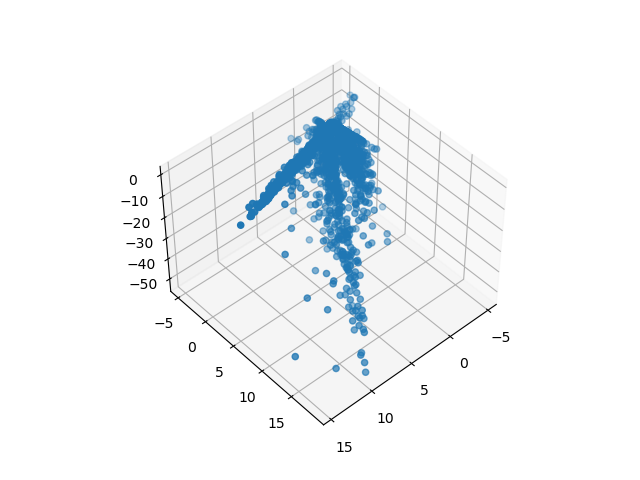

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_test[:n,0], outputs_test[:n,1],outputs_test[:n,2])
fig.show()

<IPython.core.display.Javascript object>


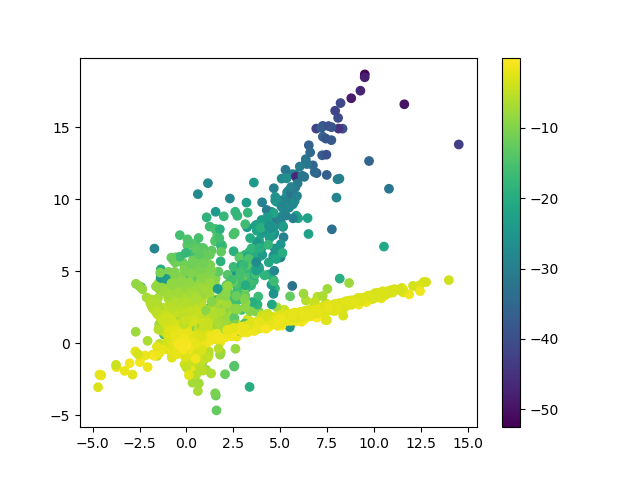

In [49]:
plt.figure()

sc = plt.scatter(outputs_test[:n,0], outputs_test[:n,1], c = outputs_test[:n,2])
plt.colorbar(sc)
plt.show()

### Plot  input and output distributions

In [50]:
AE_output = model.forward(data_test).detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test
df_test_tmp['AE'] = 'Inputs'

In [51]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(n)

<IPython.core.display.Javascript object>


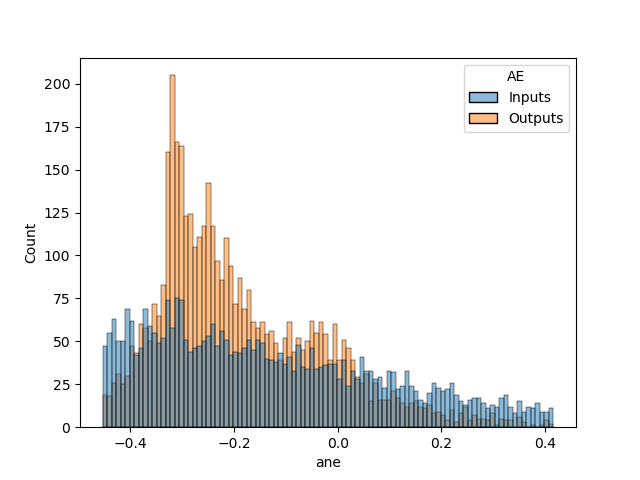

<IPython.core.display.Javascript object>


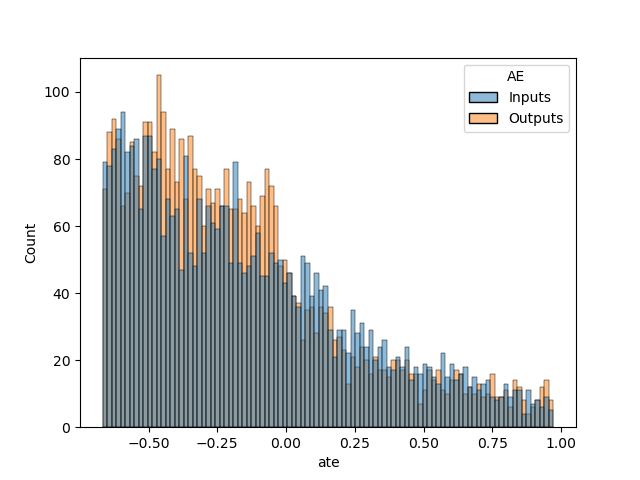

<IPython.core.display.Javascript object>


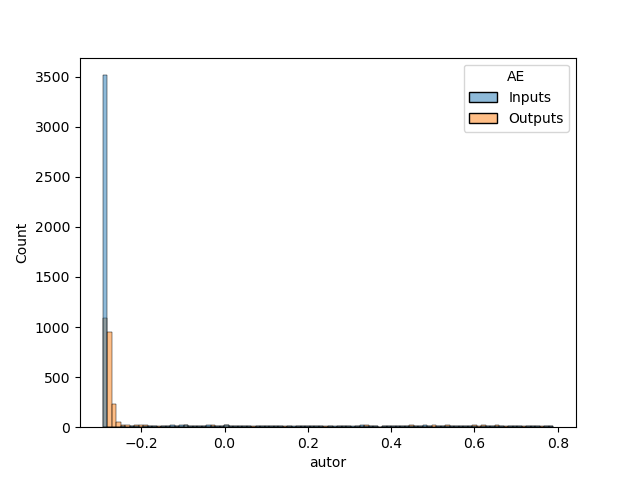

<IPython.core.display.Javascript object>


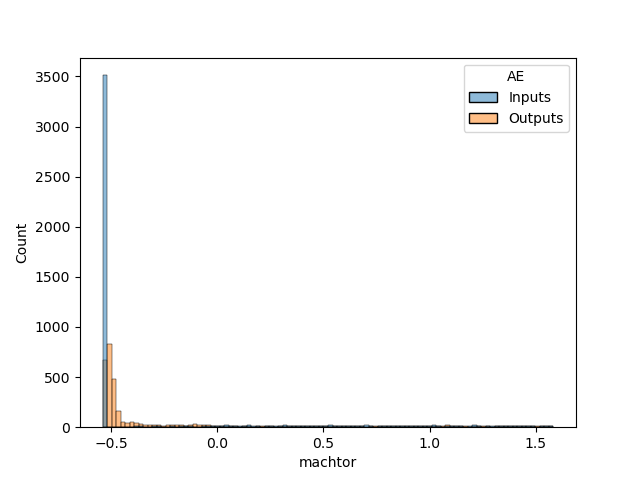

<IPython.core.display.Javascript object>


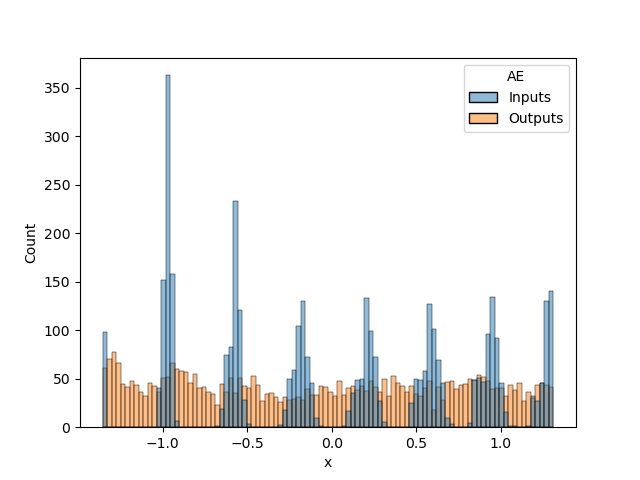

<IPython.core.display.Javascript object>


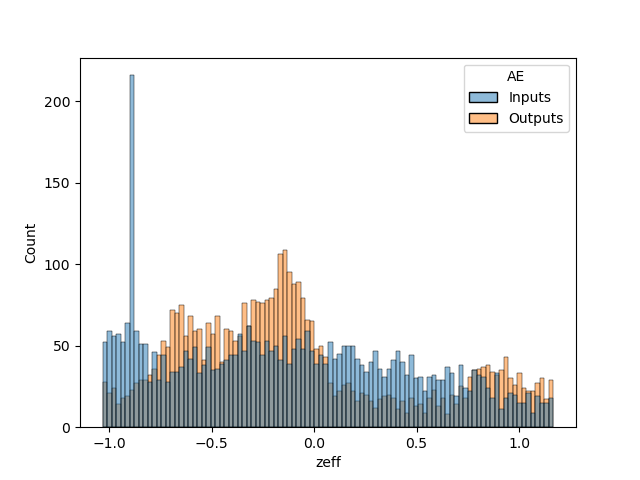

<IPython.core.display.Javascript object>


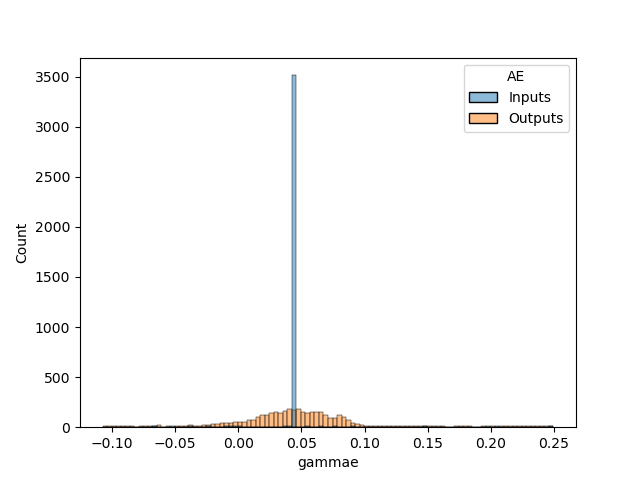

<IPython.core.display.Javascript object>


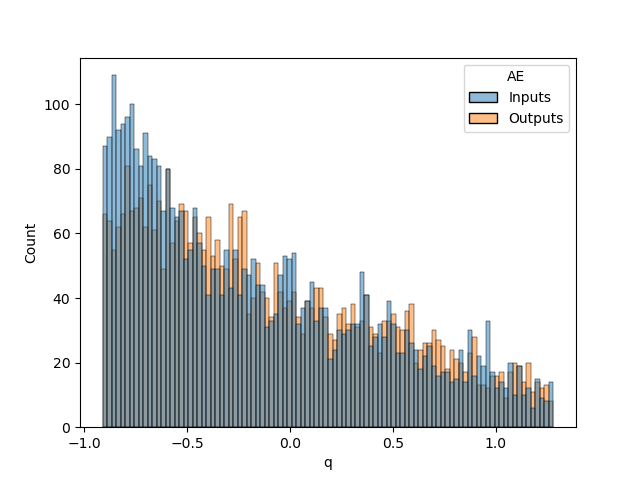

<IPython.core.display.Javascript object>


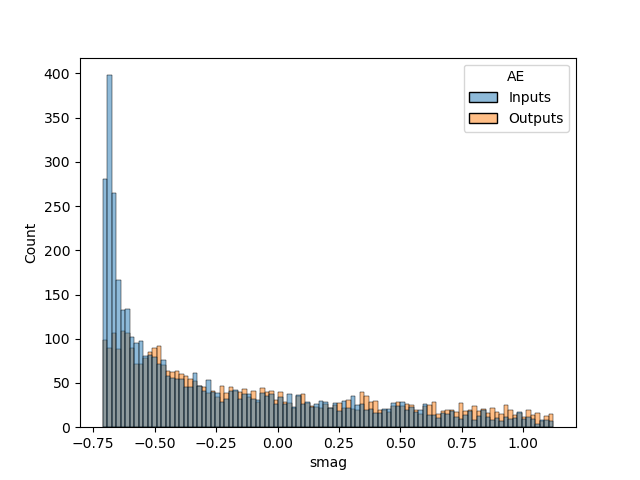

<IPython.core.display.Javascript object>


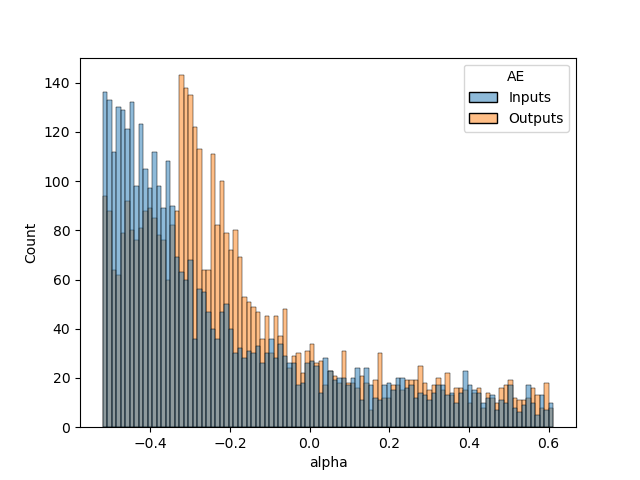

<IPython.core.display.Javascript object>


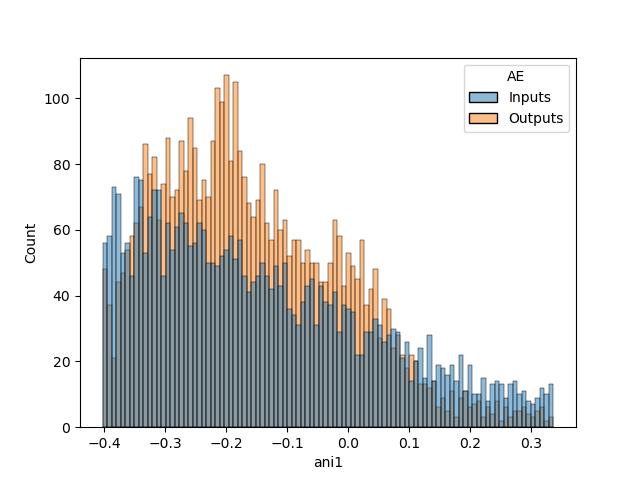

<IPython.core.display.Javascript object>


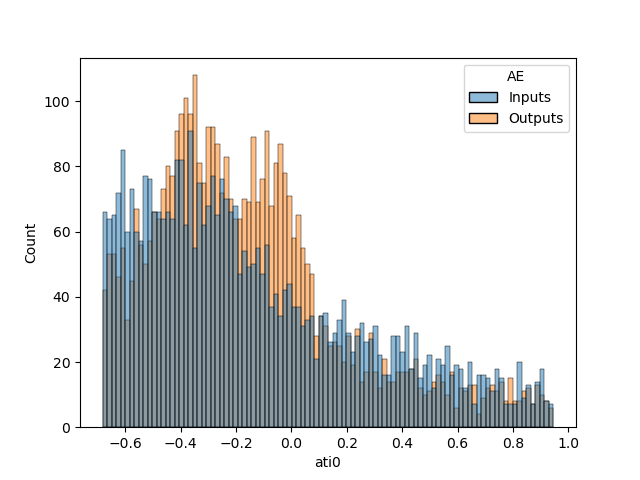

<IPython.core.display.Javascript object>


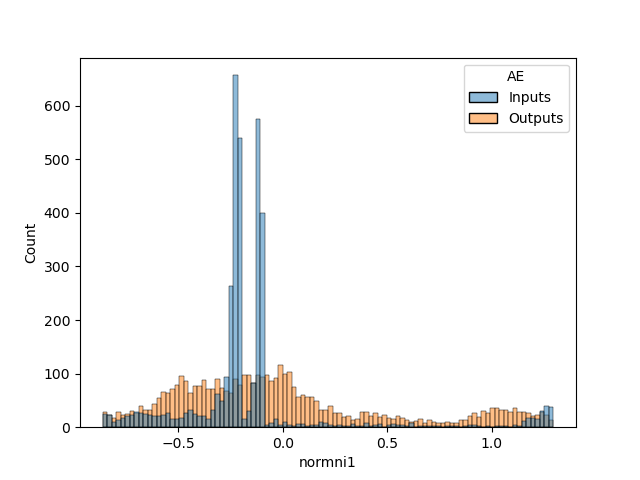

<IPython.core.display.Javascript object>


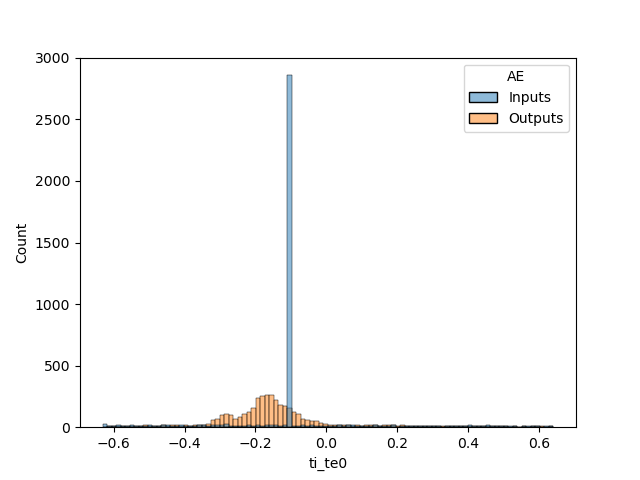

<IPython.core.display.Javascript object>


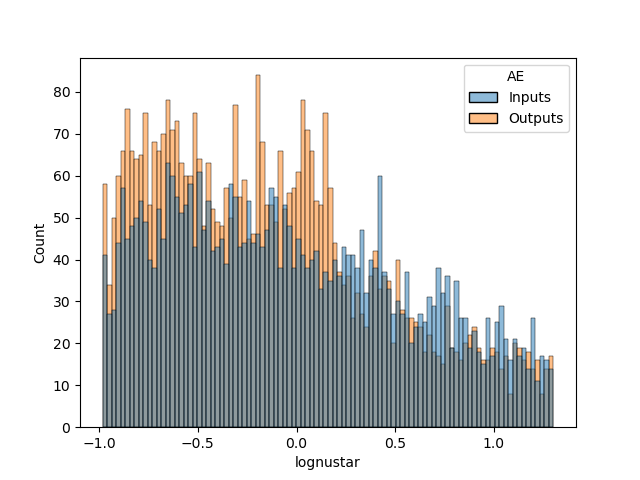

In [52]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)

### Evaluate on all inputs

In [53]:
data_test_full = torch.from_numpy(df_full_test.values).float()
outputs_test_full = encoder.forward(data_test_full).detach().numpy()

<IPython.core.display.Javascript object>


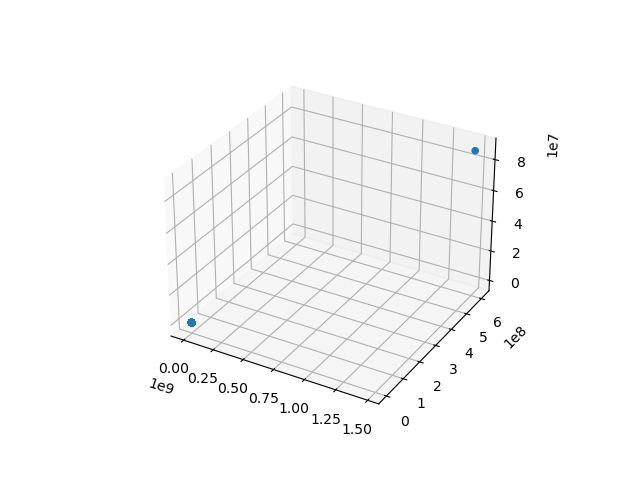

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1],outputs_test_full[:n,2])
fig.show()

In [ ]:
plt.figure()
sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
plt.colorbar(sc)
plt.show()